## Modules

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

# Store player data from 2014-2024 into dataframes

In [10]:
# Loop through years (2014-2024) and collect data points
df_list = []
for year in range(2014, 2025):
    filename = f'csv/{year}_NBA.csv'
    df = pd.read_csv(filename)
    df.insert(loc=0, column='Year', value=year)
    df_list.append(df)

all_years_df = pd.concat(df_list, ignore_index=True)

# Filter and extract information

In [11]:
def filterPlayer(name):
    return all_years_df[all_years_df['Player'] == name]

def getPlayersNames(NBA_df):
    return NBA_df['Player'].unique()

def extractData(player_df):
    extracted_data = []
    for index, row in player_df.iterrows():
        year = row['Year']
        games = row['G']
        minutes = row['MP']
        field_goal_percentage = row['FG%']
        three_point_percentage = row['3P%']
        two_point_percentage = row['2P%']
        efficiency_percentage = row['eFG%']
        free_throw_percentage = row['FT%']
        tot_reb = row['TRB']
        assist = row['AST']
        blocks = row['BLK']
        turnovers = row['TOV']
        points = row['PTS']
        
        extracted_data.append({
            'Year' : year,
            'Games' : games,
            'Minutes' : minutes,
            'FG%' : field_goal_percentage,
            '3P%' : three_point_percentage,
            '2P%' : two_point_percentage,
            'eFG%' : efficiency_percentage,
            'FT%' : free_throw_percentage,
            'TRB' : tot_reb,
            'AST' : assist,
            'BLK' : blocks,
            'TOV' : turnovers,
            'PTS' : points
        })
        
    return extracted_data


# Predictions

In [12]:
from sklearn.linear_model import LinearRegression

def predictStats(player_extracted_data):
    player_df = pd.DataFrame(player_extracted_data)
    
    # predict points, assist, and rebounds within year 2025
    predicted_years = pd.DataFrame({'Year':[2025]})
    predicted_stats = {}

    # Independent variables    
    x_years = player_df[['Year']].values

    # Dependent variables
    y_pts = player_df[['PTS']]
    y_ast = player_df[['AST']]
    y_reb = player_df[['TRB']]
    
    model_pts = LinearRegression()
    model_ast = LinearRegression()
    model_reb = LinearRegression()
    
    model_pts.fit(x_years,y_pts)
    model_ast.fit(x_years,y_ast)
    model_reb.fit(x_years,y_reb)
    
    # Predict and store into dict
    for year in predicted_years['Year']:
        predicted_stats[year] = {
            'PTS' : model_pts.predict([[year]])[0],
            'AST' : model_ast.predict([[year]])[0],
            'TRB' : model_reb.predict([[year]])[0]
        }

    # Calculate R-Square testing
    print("R-Squared pts: ", model_pts.score(x_years, y_pts))
    print("R-Squared ast: ", model_ast.score(x_years, y_ast))
    print("R-Squared reb: ", model_reb.score(x_years, y_reb))
    
    return predicted_stats
    

# Tkinter application

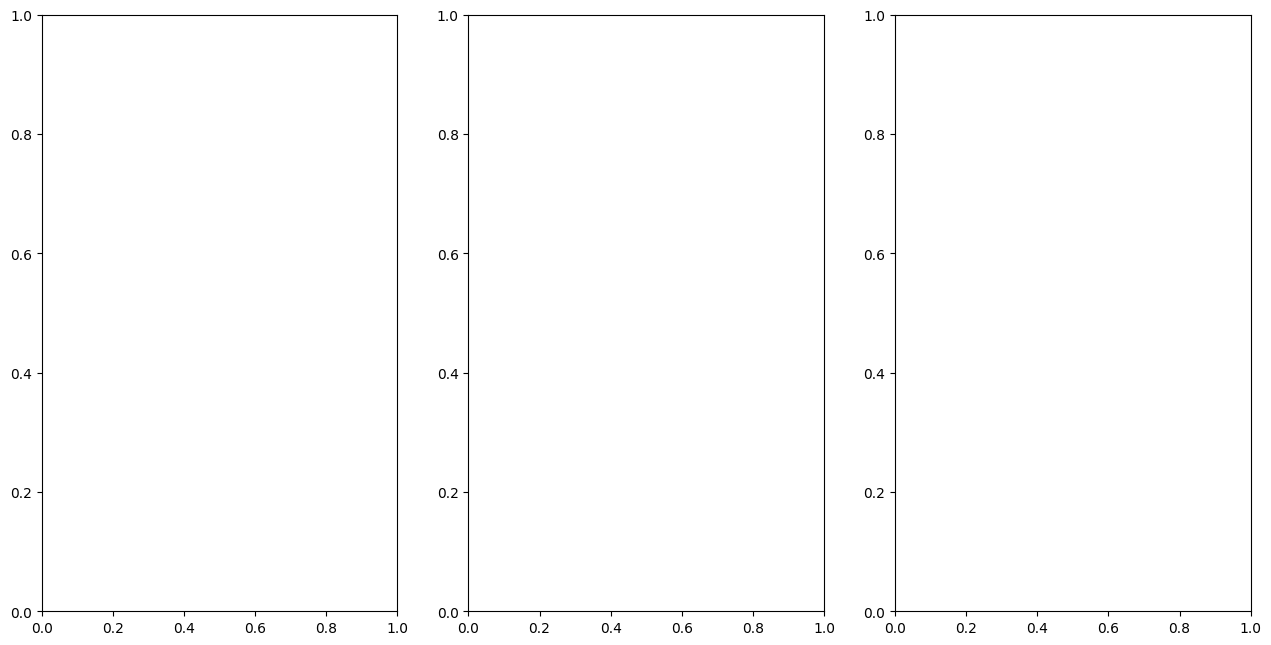

In [17]:
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from tkinter import *

playersNamesList = getPlayersNames(df)

def playerSelect(event):
    selected_player = playerList_tree.get(playerList_tree.curselection())
    player_data = filterPlayer(selected_player)
    player_extracted_data = extractData(player_data)
    player_projected_stats = predictStats(player_extracted_data)
    updatePlayerInfo(player_data, player_projected_stats)

    
def updatePlayerBox(playersNamesList):
    # clear the players list
    playerList_tree.delete(0,END)
    
    # add players to player list
    for player in playersNamesList:
        playerList_tree.insert(END, player)
    
def updatePlayerInfo(player_data, player_projected_stats):
    # Update player info when selected
    player_data_2024 = player_data[player_data['Year'] == 2024]
    player_info_name_label.config(text="Player Name: " + player_data['Player'].values[0])
    player_info_age_label.config(text="Player Age: " + str(player_data_2024['Age'].values[0]))
    player_info_tm_label.config(text="Team: " + str(player_data_2024['Tm'].values[0] ))

    year = list(player_projected_stats.keys())[0]
    stats = player_projected_stats[year]
    pts = stats['PTS'][0]
    ast = stats['AST'][0]
    trb = stats['TRB'][0]

    player_predict_pts_value.config(text=f"{pts:.2f}")
    player_predict_ast_value.config(text=f"{ast:.2f}")
    player_predict_rb_value.config(text=f"{trb:.2f}")

    updatePlot(player_data, player_projected_stats)

def updatePlot(player_data, player_projected_stats):
    
    # Calculate average points per game for each year from starting year or 2014
    if player_data['Year'].values[0] == 2014:
        year_start = 2014
    else:
        year_start = player_data['Year'].values[0]

    years_range = list(range(year_start, 2025))
    player_career = pd.DataFrame({
        'Year': years_range,
        'Average Points Per Game': [player_data.loc[player_data['Year'] == year, 'PTS'].values[0] if year in player_data['Year'].values else 0 for year in years_range]
    })
    

    
    # Linear regression model
    X = player_data[['Year']]
    y = player_data[['PTS']]
    model = LinearRegression()
    model.fit(X,y)
    
    predicted_years = pd.DataFrame({'Year': [2025,2026]})
    predicted_points = model.predict(predicted_years) 

    
    for ax in axes:
        ax.clear()
    
    # Plot regression line model
    sns.regplot(x='Year', y='Average Points Per Game', data=player_career, ax=axes[0])
    axes[0].set_title('Regression Line: Year vs PTS')
    axes[0].plot(X, model.predict(X), color='red', linestyle='-', linewidth=2, label='Regression Line')
    axes[0].scatter(predicted_years, predicted_points, color='green', marker='*', s=100, label='Predicted Points')
    axes[0].legend()
    
    
    # retrieve players data for correlation matrix
    player_cor_data = pd.DataFrame(player_data, columns=['G', 'MP', 'FG%', 
                                                     '3P%', '2P%', 'eFG%', 
                                                     'FT%', 'TRB', 'AST', 
                                                     'BLK', 'TOV', 'PTS'])

    # plot correlation matrix
    matrix = player_cor_data.corr()
    
    # Create heatmap using Matplotlib
    heatmap = axes[1].imshow(matrix, cmap='Blues')
    
    # Show values in each cell
    for i in range(len(matrix)):
        for j in range(len(matrix)):
            axes[1].text(j, i, f'{matrix.iloc[i, j]:.2f}', ha='center', va='center', color='black')
    
    # Set x and y labels
    variables = list(matrix.columns)
    axes[1].set_xticks(range(len(matrix)))
    axes[1].set_xticklabels(variables, rotation=45, ha='right')
    axes[1].set_yticks(range(len(matrix)))
    axes[1].set_yticklabels(variables)
    axes[1].invert_yaxis()
    axes[1].set_title('Correlation Matrix')
    
    # plot histogram
    axes[2].bar(player_career['Year'], player_career['Average Points Per Game'], color='purple')
    axes[2].set_xlabel('Year')
    axes[2].set_ylabel('Average Points Per Game')
    axes[2].set_title('Average Points Per Game by Year')
    axes[2].set_xticks(player_career['Year'])
    axes[2].tick_params(axis='x', rotation=45)
    axes[2].grid(axis='y', linestyle='--', alpha=0.7)
    
    canvas.draw()
    

def fillout(event):
    # Clear entry box
    search_entry.delete(0, END)
    
    # Add list item to entry box
    search_entry.insert(0, playersNamesList.get(ANCHOR))
    
def checkList(event):
    # retrieve user typed entry
    typed = search_entry.get()
    
    if typed == '':
        name = playersNamesList
    else:
        name = []
        for players in playersNamesList:
            if typed.lower() in players.lower():
                name.append(players)
                
    #update listbox with selected players
    updatePlayerBox(name)
    
root = Tk()
root.title("NBA Stat Predictor")
root.geometry("1600x1200")

player = StringVar(root)
player.set(playersNamesList[0])

topFrame = Frame(root, width=1200, height=300, padx=10, pady=10)
topFrame.pack(side='top', fill='x')

bottomFrame = Frame(root, width=1200, height=700, padx=10, pady=10)
bottomFrame.pack(side='bottom', fill='both', expand=True)

playerListFrame = Frame(topFrame, width=100, height=300, padx=10, pady=10)
playerListFrame.pack(side='left', fill='y')

playerInfoFrame = Frame(topFrame, width=450, height=300, padx=10, pady=10)
playerInfoFrame.pack(side='left', fill='y')

playerPredictionFrame = Frame(topFrame, width=250, height=300, padx=10, pady=10)
playerPredictionFrame.pack(side='left', fill='y')

plotsFrame = Frame(bottomFrame, width=1200, height=700, padx=10, pady=10)
plotsFrame.pack(side='bottom', fill='both', expand=True)

# playerListFrame init
playerList_tree = Listbox(playerListFrame, width=50)
search_label = Label(playerListFrame, text="Search player name", fg="grey")
search_entry = Entry(playerListFrame)
reference_label = Label(playerListFrame, text="Data sourced from basketball-reference.com", fg="black")

#playerInfoFrame init
player_info_name_label = Label(playerInfoFrame, text="Player Name: ", fg="black")
player_info_name_value = Label(playerInfoFrame, text="", fg="black")
player_info_age_label = Label(playerInfoFrame, text="Age: ", fg="black")
player_info_age_value = Label(playerInfoFrame, text="", fg="black")
player_info_tm_label = Label(playerInfoFrame, text="Team: ", fg="black")
player_info_tm_value = Label(playerInfoFrame, text="", fg="black")

# playerPredictionFrame init
player_predict_pts_label = Label(playerPredictionFrame, text="Projected Points: ", fg="green")
player_predict_pts_value = Label(playerPredictionFrame, text="", fg="black")
player_predict_ast_label = Label(playerPredictionFrame, text="Projected Assists: ", fg="purple")
player_predict_ast_value = Label(playerPredictionFrame, text=" ", fg="black")
player_predict_rb_label = Label(playerPredictionFrame, text="Projected Rebounds: ", fg="blue")
player_predict_rb_value = Label(playerPredictionFrame, text="", fg="black")

# playerVisualFrame init
fig, axes = plt.subplots(1, 3, figsize=(6,9))
canvas = FigureCanvasTkAgg(fig, master=plotsFrame)
canvas.draw()

# playerListFrame search bar
search_label.pack(pady=5)

# playerListFrame Search entry
search_entry.pack(pady=5)

# playerListFrame player list tree
playerList_tree.pack(pady=20)
updatePlayerBox(playersNamesList)
reference_label.pack(pady=30)

# playerListFrame Binding on the listbox event (onclick)
playerList_tree.bind("<<ListboxSelect>>", playerSelect)

# playerListFrame Binding on the entry box
search_entry.bind("<KeyRelease>", checkList)

# playerInfoFrame player labels and values
player_info_name_label.grid(row=0, column=0, sticky=W, padx=5, pady=5)
player_info_name_value.grid(row=0, column=1, sticky=W, padx=5, pady=5)
player_info_age_label.grid(row=1, column=0, sticky=W, padx=5, pady=5)
player_info_age_value.grid(row=1, column=1, sticky=W, padx=5, pady=5)
player_info_tm_label.grid(row=2, column=0, sticky=W, padx=5, pady=5)
player_info_tm_value.grid(row=2, column=1, sticky=W, padx=5, pady=5)

# playerPredictionFrame player labels and values
player_predict_pts_label.grid(row=0, column=0, sticky=W, padx=5, pady=5)
player_predict_pts_value.grid(row=0, column=1, sticky=W, padx=5, pady=5)
player_predict_ast_label.grid(row=1, column=0, sticky=W, padx=5, pady=5)
player_predict_ast_value.grid(row=1, column=1, sticky=W, padx=5, pady=5)
player_predict_rb_label.grid(row=2, column=0, sticky=W, padx=5, pady=5)
player_predict_rb_value.grid(row=2, column=1, sticky=W, padx=5, pady=5)

# Add plot to the GUI
canvas.get_tk_widget().pack(side=TOP, fill=BOTH, expand=True)


root.mainloop()
